# House Sales Analysis Notebook

Part of CRISP-DM Data Understanding

## Objectives

* Data Exploration using ProfileReport

## Inputs

* outputs/datasets/collection/house_prices_records.csv

## Outputs

* Generate correlation plots to be included in streamlit app.

---

## Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing'

## Load Data

In [4]:
import pandas as pd
df_house_prices = pd.read_csv(f"outputs/datasets/collection/house_prices_records.csv")
df_house_prices.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Data Exploration

We are interested to get more familiar with the dataset, check variable type and distribution, missing levels and what these variables mean.
* Explore the data with ProfileReport

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df_house_prices, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Study

* We are trying to identify if there are any correlations between the variables and the Sale Price of the house.
* We will use .corr() for spearman and pearson methods, and investigate the correlations against the SalePrice variable.
* The r values below is between -1 (negative) and 1 (positive) to determine the strength of the correlation.
* With these methods we will use SalePrice values to gather correlation values and sort them by absolute (abs) values.

* Using correlation and predictive power score (PPS) we can carry out an initial assessment of the relationship between the different variables. 
* The functions used below are as guidance following the CI Walkthrough project 2.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df_house_prices, threshold, figsize=(20,12), font_annot=8):
    if len(df_house_prices.columns) > 1:
        mask = np.zeros_like(df_house_prices, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df_house_prices) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df_house_prices, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes, 
                    linewidth=0.5
                    )
        axes.set_yticklabels(df_house_prices.columns, rotation=0)
        plt.ylim(len(df_house_prices.columns), 0)
        plt.show()


def heatmap_pps(df_house_prices, threshold, figsize=(20, 12), font_annot=8):
    if len(df_house_prices.columns) > 1:
        mask = np.zeros_like(df_house_prices, dtype=np.bool)
        mask[abs(df_house_prices) < threshold] = True

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df_house_prices, annot=True, xticklabels=True, yticklabels=True, mask=mask,
                        cmap='rocket_r',
                        annot_kws={"size": font_annot}, linewidth=0.05, linecolor='grey')
        plt.ylim(len(df_house_prices.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df_house_prices)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS theshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):
    
    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df_house_prices=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df_house_prices=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
         f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df_house_prices=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Then we use CalculateCorrAndPPS to calculate Correlations and Power Predictive Score

In [7]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_house_prices)

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("

PPS theshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



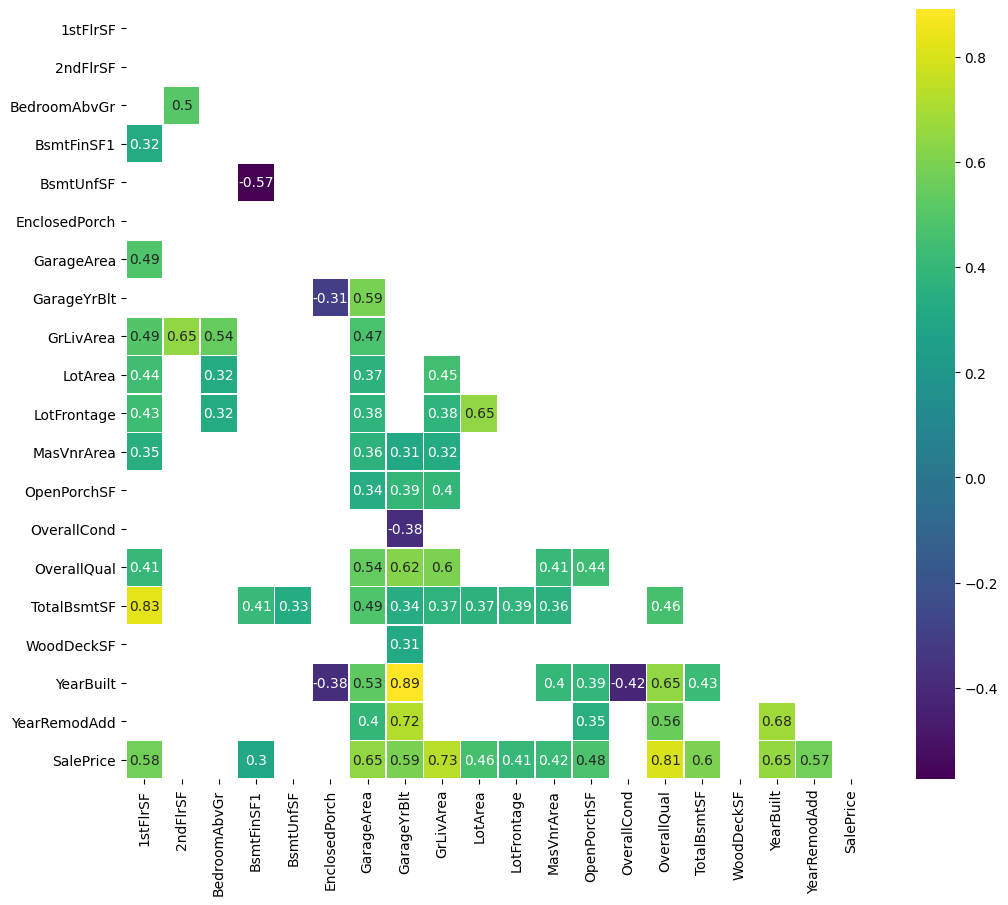



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



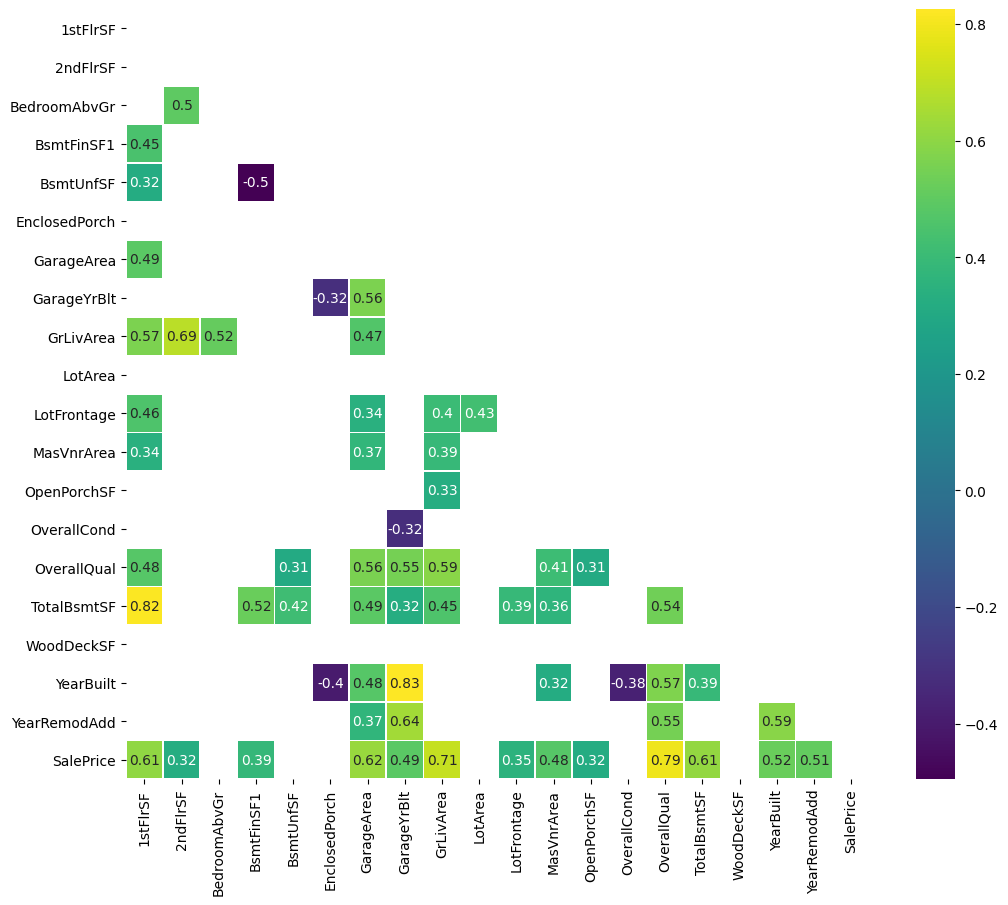



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



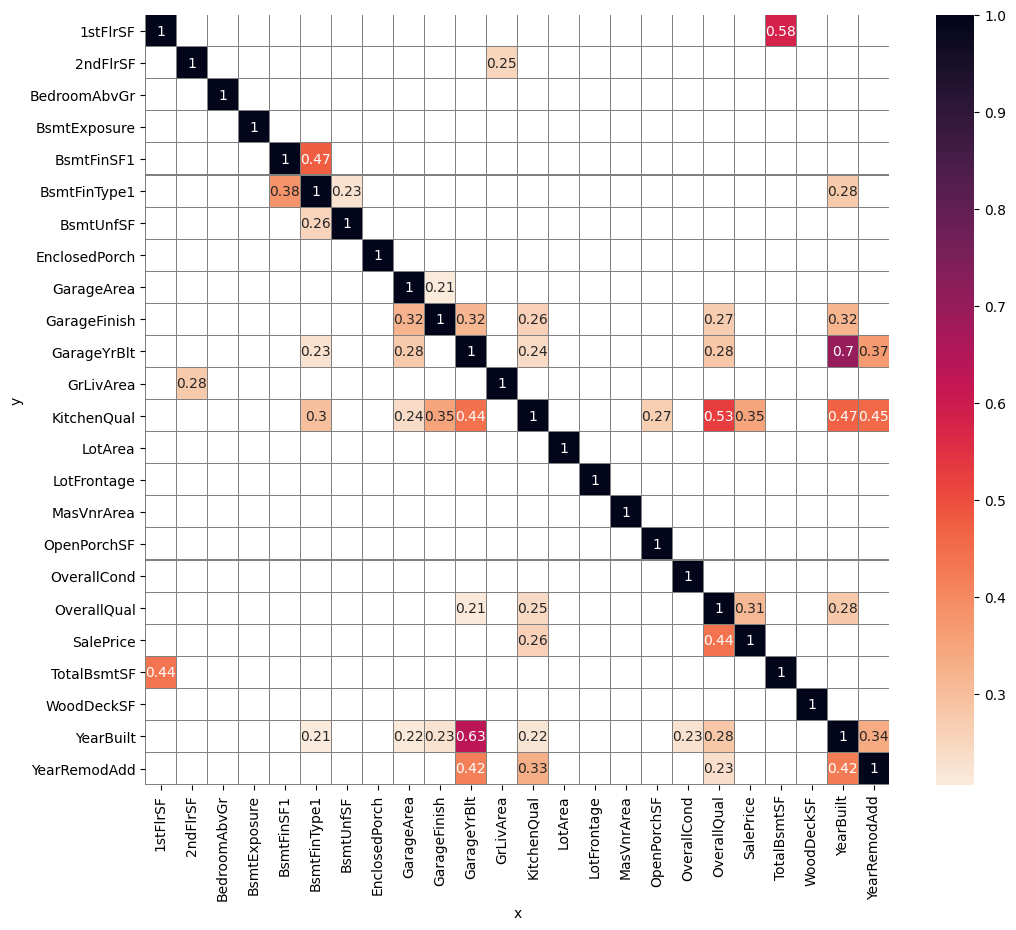

In [8]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                    df_corr_spearman = df_corr_spearman,
                    pps_matrix = pps_matrix,
                    CorrThreshold = 0.3, PPS_Threshold = 0.2,
                    figsize=(12,10), font_annot = 10)

#### Spearman Method:

* The Spearman correlation looks at the monotonic relationship between two variables. The method ranks the values of both variables and measures the difference between the two ranks.
* Using the correlation cooefficient we will be able to determine how strong the correlation is (between -1 and 1) and in which direction the correlation is going.
* We are looking for the top 10 most correlations.

In [9]:
salesprice_corr_spearman = df_house_prices.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
salesprice_corr_spearman 

OverallQual     0.809829
GrLivArea       0.731310
YearBuilt       0.652682
GarageArea      0.649379
TotalBsmtSF     0.602725
GarageYrBlt     0.593788
1stFlrSF        0.575408
YearRemodAdd    0.571159
OpenPorchSF     0.477561
LotArea         0.456461
Name: SalePrice, dtype: float64

#### Pearson Method:

* The Pearson correlation looks at the linear relationship between two variables as they change at a constant rate, this method uses the raw data. We can measure how strong the correlation is and in which direction the correlation is going (positive, negative or no correlation).
* We are looking for the top 10 most correlations.

In [10]:
salesprice_corr_pearson = df_house_prices.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
salesprice_corr_pearson

OverallQual     0.790982
GrLivArea       0.708624
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

The values are ranging between 0.3 and 0.79 which represents moderate to strong correlation levels.

We are now going to consider the top 5 correlation levels (or any above 0.6). We will convert these correlations into lists and concatenate.

In [11]:
top_n = 5
vars_to_study = set(salesprice_corr_spearman[:top_n].index.to_list() + salesprice_corr_pearson[:top_n].index.to_list())
vars_to_study

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

Six variables were provided (this id due to two variables that were the 5th highest correlation level in either of the methods). We are going to use these variables and investigate if:
HYPOTHESIS HERE

In [12]:
vars_to_study = ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

## EDA on selected variables

Next we are going to show the selected variables above with SalePrice:

In [13]:
df_eda = df_house_prices.filter(vars_to_study + ['SalePrice'])
df_eda.head()

,1stFlrSF,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,856,548,1710,7,856,2003,208500
1,1262,460,1262,6,1262,1976,181500
2,920,608,1786,7,920,2001,223500
3,961,642,1717,7,756,1915,140000
4,1145,836,2198,8,1145,2000,250000


Now we are going to distribute it by SalesPrice:

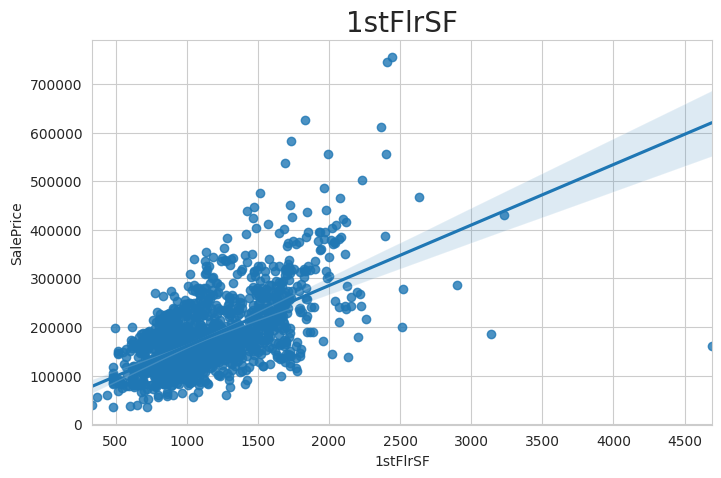

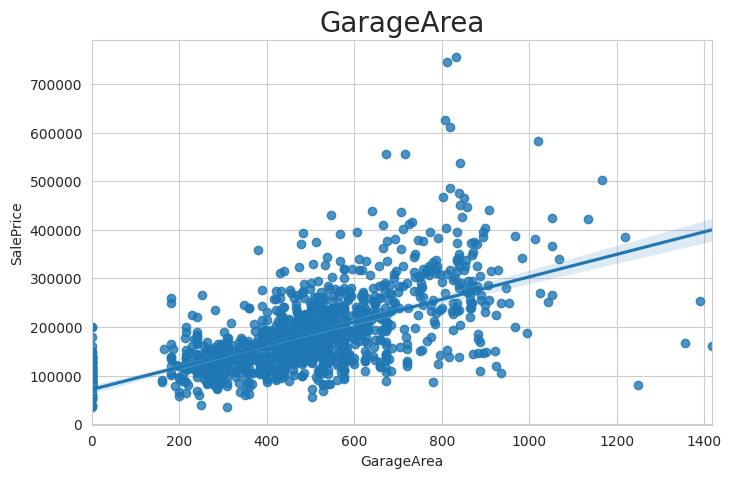

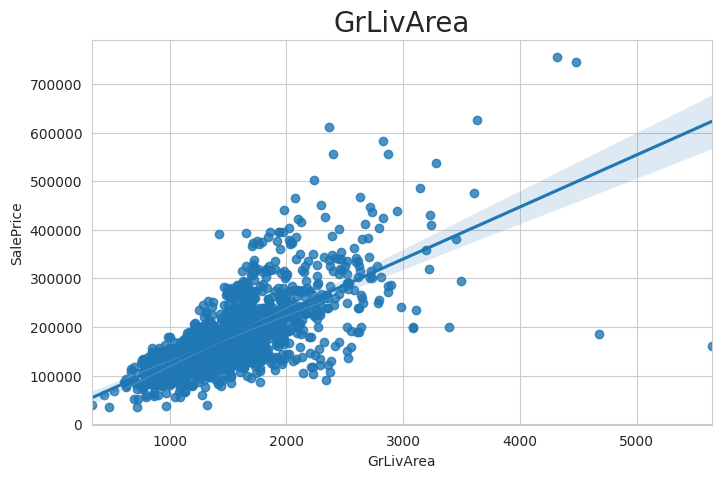

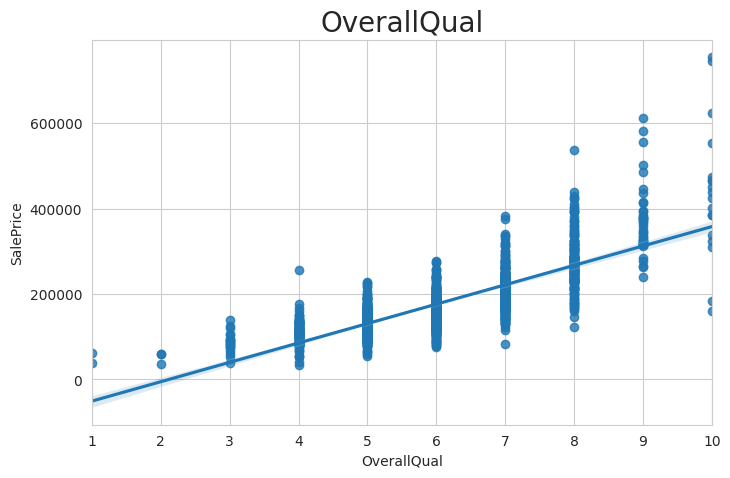

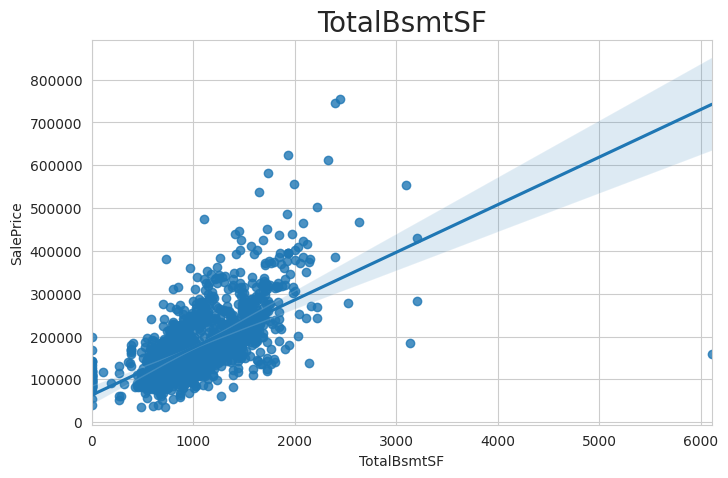

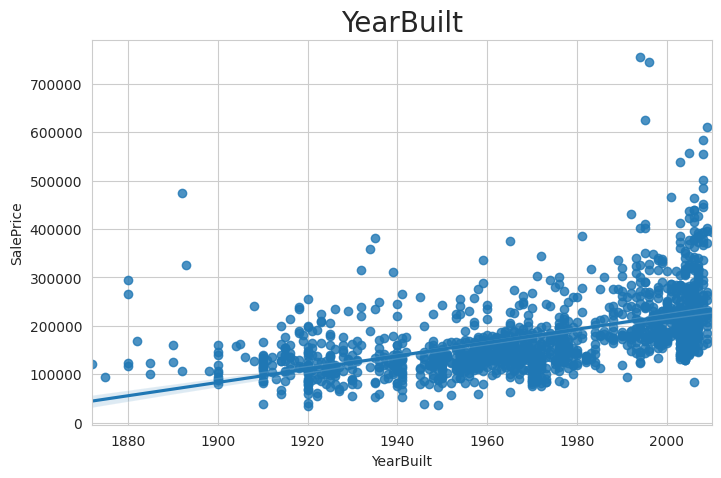

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

def plot_categorical(df_eda, col, target_var):

    plt.figure(figsize=(8, 5))
    sns.regplot(data=df_eda, x=col, y=target_var, order=df_eda[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f"{col}", fontsize=20)
    plt.show()

def plot_numerical(df_eda, col, target_var):

    plt.figure(figsize=(8,5))
    sns.regplot(data=df_eda, x=col, y=target_var)
    plt.title(f"{col}", fontsize=20)
    plt.show()


target_var = 'SalePrice'
for col in vars_to_study:
    if df_eda[col].dtype == 'object':
        plot_catgorical(df_eda, col, target_var)
        print("\n\n")
    else:
        plot_numerical(df_eda, col, target_var)
        print("\n\n")


### Findings

* Overall Quality has the biggest effect on Sale Price
* 1st Floor Square footage size, Ground living Area, Size of Garage Area and Basement show to have an effect on the Sale Price.
* The Year the home was built will have an impact on the Sale Price.